In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

return_number = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

def convert_date(d):
    try:
        return datetime.date(year=int(d[4:]), month=return_number[d[:3]], day=1)
    except:
        pass

loan['issue_d'] = loan['issue_d'].apply(convert_date)
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(convert_date)

loan = loan[loan.issue_d < datetime.date(2015,7,1)]
loan = loan[loan.issue_d >= datetime.date(2010,1,1)]

loan = loan[loan.term == ' 36 months']

loan['earliest_cr_line'] = loan.apply(lambda x: (x['issue_d'] - x['earliest_cr_line']).days, axis=1)

loan = loan[(loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Charged Off')]

loan = loan[loan.annual_inc < 1000000]

loan['ln_annual_inc'] = np.log(loan.annual_inc)

loan = loan[loan.revol_util < 150]
loan['ln_revol_bal'] = np.log(loan.revol_bal+1)

loan['ln_earliest_cr_line'] = np.log(loan.earliest_cr_line)

loan['ln_open_acc'] = np.log(loan.open_acc)

loan.rename(columns = {'delinq_2yrs': 'num_delinq_2yrs'}, inplace=True)
loan['delinq_2yrs'] = (loan['num_delinq_2yrs'] >= 1)

loan.rename(columns = {'pub_rec': 'num_pub_rec'}, inplace=True)
loan['pub_rec'] = (loan['num_pub_rec'] >= 1)

loan.rename(columns = {'inq_last_6mths': 'num_inq_last_6mths'}, inplace=True)
loan['inq_last_6mths'] = (loan['num_inq_last_6mths'] >= 1)

loan['target'] = (loan['loan_status'] == 'Fully Paid')

In [2]:
col_list = ['loan_amnt', 'int_rate', 'ln_annual_inc', 'dti', 'fico_range_high', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'num_inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'ln_open_acc', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']


In [3]:
# We will use 2010-2013 to tune our models, and save data from 2014 and the first 
# 6 months of 2015 for walk-forward testing

train = loan[loan.issue_d < datetime.date(2014, 1, 1)]
test = loan[(loan.issue_d >= datetime.date(2014, 1, 1)) & (loan.issue_d < datetime.date(2015, 7, 1))]


In [4]:
y = train['target']
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2 = pd.concat([X1, train.int_rate, pd.get_dummies(train.grade)], axis=1)
X3 = pd.concat([X1, train.int_rate, pd.get_dummies(train.sub_grade)], axis=1)


In [5]:
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.grade)], axis=1)
X3_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.sub_grade)], axis=1)
y_test = test['target']

In [6]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time

start = time.time()
rfc1 = ensemble.RandomForestClassifier(max_depth=5, max_features=5, n_estimators=50)
scores = cross_val_score(rfc1, X1, y, cv=10)
time_elapsed = time.time()-start
print(scores.mean())
print(time_elapsed)



0.8761131128523608
73.02458190917969


In [7]:
rfc1.fit(X1, y)


for i in range(X1.shape[1]):
    print('{}: {}'.format(X1.columns[i], rfc1.feature_importances_[i]))


loan_amnt: 0.014289652992040356
ln_annual_inc: 0.285113878781244
dti: 0.08519454684815743
fico_range_high: 0.39651236517667326
delinq_2yrs: 0.0005100033988624577
num_delinq_2yrs: 0.0013979795090257438
ln_earliest_cr_line: 0.019989394715298155
inq_last_6mths: 0.03840629742141021
num_inq_last_6mths: 0.06515147452090829
ln_open_acc: 0.006247386832713576
pub_rec: 0.0006894047429539883
num_pub_rec: 0.0019219168860923242
ln_revol_bal: 0.022929623020434525
revol_util: 0.04861150012885425
total_acc: 0.013034575025331363


In [8]:
X1.shape

(166313, 15)

In [9]:
rfc1.feature_importances_

array([0.01428965, 0.28511388, 0.08519455, 0.39651237, 0.00051   ,
       0.00139798, 0.01998939, 0.0384063 , 0.06515147, 0.00624739,
       0.0006894 , 0.00192192, 0.02292962, 0.0486115 , 0.01303458])

In [10]:
pred1 = rfc1.predict_proba(X1_test)

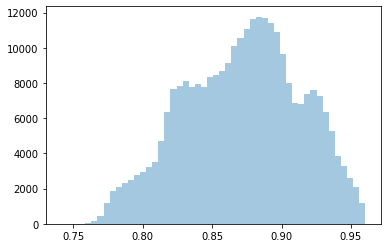

In [11]:
sns.distplot([x[1] for x in pred1], kde=False)

In [12]:
test['pred1'] = [x[1] for x in pred1]

In [13]:
test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt


In [14]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt

for letter in letters:
    thresh_m1_80 = np.percentile(test[test.grade == letter]['pred1'], q=80)

    thresh_m1_90 = np.percentile(test[test.grade == letter]['pred1'], q=90)

    thresh_m1_95 = np.percentile(test[test.grade == letter]['pred1'], q=95)
    
    thresh_m1_99 = np.percentile(test[test.grade == letter]['pred1'], q=99)

    print('-----------------  ' + letter + '  -----------------')
    print('')
    
    print('Naive Returns:       {}'.format(test[test.grade==letter]['pct_return'].mean()*100))
    
    print('')
    print('Model 1:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_99)]['pct_return'].mean()*100))

    print('\n')

-----------------  A  -----------------

Naive Returns:       7.141438714524952

Model 1:
>80th percentile:    7.290941183931412
>90th percentile:    7.226963830014774
>95th percentile:    7.198647338606939
>99th percentile:    6.903267650532419


-----------------  B  -----------------

Naive Returns:       8.71693709483582

Model 1:
>80th percentile:    9.283287279297497
>90th percentile:    9.19348195571475
>95th percentile:    8.942152361998774
>99th percentile:    9.156598942704898


-----------------  C  -----------------

Naive Returns:       8.296905799613116

Model 1:
>80th percentile:    9.787935089214436
>90th percentile:    9.862420164870063
>95th percentile:    9.9441315143474
>99th percentile:    9.697024305084206


-----------------  D  -----------------

Naive Returns:       7.915659945631005

Model 1:
>80th percentile:    9.340113137340818
>90th percentile:    9.258636615365441
>95th percentile:    8.889565753490857
>99th percentile:    8.888950540344148


------------

In [15]:
'''from sklearn.model_selection import GridSearchCV

par am_grid = {
    'max_depth': [1, 2, 3, 5, 10, 20, 40],
    'max_features': [2, 3, 4, 5],
    'n_estimators': [10, 50, 100, 500]
}

param_grid2 = {
    'max_depth': [2,3,5],
    'max_features': [2,3],
    'n_estimators': [50]
}

rf = ensemble.RandomForestClassifier()

start = time.time()
grid_search = GridSearchCV(estimator=rf, param_grid = param_grid, cv=3)
grid_search.fit(X1, y)
elapsed = time.time()-start

print(grid_search.best_params_)
print('{} seconds'.format(round(elapsed, 0)))
'''

"from sklearn.model_selection import GridSearchCV\n\npar am_grid = {\n    'max_depth': [1, 2, 3, 5, 10, 20, 40],\n    'max_features': [2, 3, 4, 5],\n    'n_estimators': [10, 50, 100, 500]\n}\n\nparam_grid2 = {\n    'max_depth': [2,3,5],\n    'max_features': [2,3],\n    'n_estimators': [50]\n}\n\nrf = ensemble.RandomForestClassifier()\n\nstart = time.time()\ngrid_search = GridSearchCV(estimator=rf, param_grid = param_grid, cv=3)\ngrid_search.fit(X1, y)\nelapsed = time.time()-start\n\nprint(grid_search.best_params_)\nprint('{} seconds'.format(round(elapsed, 0)))\n"

In [17]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [1,2,3,5,7,10,15,20,25,30,40,50,70,90],
    'max_features': [2,3,4,5,7,10,15],
    'n_estimators': [50]
}

rf2 = ensemble.RandomForestClassifier()

rf2_random = RandomizedSearchCV(estimator=rf2, param_distributions = param_grid, n_iter=40, cv=3)

rf2_random.fit(X1, y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [21]:
rf2_random.best_params_

{'n_estimators': 50, 'max_features': 3, 'max_depth': 10}

In [23]:
rf3 = ensemble.RandomForestClassifier(n_estimators=50, max_features=3, max_depth=10)

rf3.fit(X1, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
test['pred2'] = [x[1] for x in rf3.predict_proba(X1_test)]

def returns_by_grade(metric, grade, returns, thresh = [80, 90, 95]):
    for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        
        cutoffs = [np.percentile(metric[grade == letter], q=x) for x in thresh]
        
        print('--------------  ' + letter + '  --------------')
        print('')
    
        print('Naive Returns:             {}%'.format(round(returns[grade==letter].mean()*100, 2)))
        print('')
        
        for c in range(len(thresh)):
            print('{} Percent Cutoff:         {}%'.format(thresh[c], round(returns[(grade == letter) & (metric >= cutoffs[c])].mean()*100,2)))
            
        print('')
        
returns_by_grade(test.pred2, test.grade, test.pct_return)

#test[['pred2', 'grade', 'pct_return']]

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         7.26%
90 Percent Cutoff:         7.06%
95 Percent Cutoff:         7.21%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         9.54%
90 Percent Cutoff:         9.36%
95 Percent Cutoff:         9.18%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         10.1%
90 Percent Cutoff:         10.51%
95 Percent Cutoff:         10.48%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         9.9%
90 Percent Cutoff:         9.86%
95 Percent Cutoff:         10.2%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         9.68%
90 Percent Cutoff:         9.63%
95 Percent Cutoff:         8.76%

--------------  F  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         13.48%
90 Percent Cutoff:         12.73%
95 Percent Cutoff:

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test.target, test.pred2)

0.6430868590304116

In [45]:
roc_auc_score(test.target, test.pred1)

0.6340219482661359

Our model with optimized hyperparameters did improve the model somewhat over manual selection of parameteres.

In [46]:
rf4 = ensemble.RandomForestClassifier(max_depth=5, max_features=5, n_estimators=50)
rf4.fit(X2, y)

test['pred3'] = [x[1] for x in rf4.predict_proba(X2_test)]

roc_auc_score(test.target, test.pred3)

0.670508753379953

In [48]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [1,2,3,5,7,10,15,20,25,30,40,50,70,90],
    'max_features': [2,3,4,5,7,10,15],
    'n_estimators': [50]
}

rf5 = ensemble.RandomForestClassifier()

rf5_random = RandomizedSearchCV(estimator=rf5, param_distributions = param_grid, n_iter=40, cv=3)

rf5_random.fit(X2, y)

KeyboardInterrupt: 

In [50]:
rf2_random.best_params_

{'n_estimators': 50, 'max_features': 4, 'max_depth': 10}

In [53]:
rf6 = ensemble.RandomForestClassifier(n_estimators=500, max_features=4, max_depth=10)

rf6.fit(X2, y)

test['pred4'] = [x[1] for x in rf6.predict_proba(X2_test)]

roc_auc_score(test.target, test.pred4)

0.6730813703587986

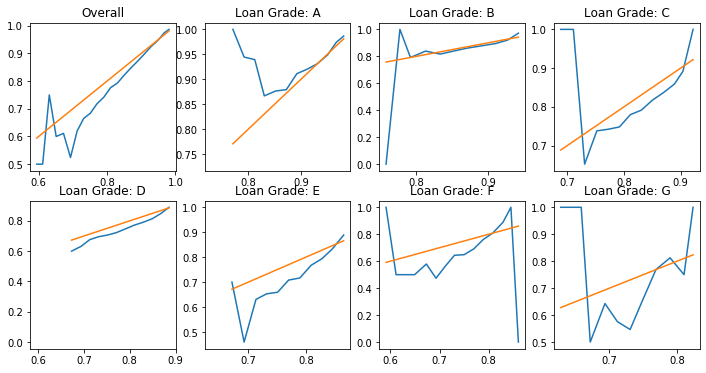

In [55]:
def graph_by_grade(predictions, grade, target):
    pred = []
    act = []
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,4,1)
    plt.title("Overall")
    
    for i in range(21):
        
        lb = .58 + i*.02
        ub = .58 + (i+1)*.02
        sub = ((predictions >= lb)&(predictions < ub))
        pred_compliance = predictions[sub].mean()
        act_compliance = target[sub].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)

    plt.plot(pred, act)
    plt.plot(pred, pred)

    for letter in range(7):
        
        pred = []
        act = []
        ss = []
        
        for i in range(21):
            lb = .58 + i*.02
            ub = .58 + (i+1)*.02
            sub = ((predictions >= lb)&(predictions < ub)&(grade==letters[letter]))
            pred_compliance = predictions[sub].mean()
            act_compliance = target[sub].mean()
            pred.append(pred_compliance)
            act.append(act_compliance)

        plt.subplot(2,4,letter+2)
        plt.title('Loan Grade: {}'.format(letters[letter]))
        plt.plot(pred, act)
        plt.plot(pred, pred)
    
    plt.show()
    
graph_by_grade(test.pred4, test.grade, test.target)

In [57]:
returns_by_grade(test.pred4, test.grade, test.pct_return, [80, 90, 95, 99])

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         7.25%
90 Percent Cutoff:         7.05%
95 Percent Cutoff:         6.98%
99 Percent Cutoff:         6.85%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         9.35%
90 Percent Cutoff:         9.24%
95 Percent Cutoff:         9.29%
99 Percent Cutoff:         9.53%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         10.08%
90 Percent Cutoff:         10.33%
95 Percent Cutoff:         10.88%
99 Percent Cutoff:         11.63%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         10.52%
90 Percent Cutoff:         11.4%
95 Percent Cutoff:         12.16%
99 Percent Cutoff:         13.76%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         11.57%
90 Percent Cutoff:         12.73%
95 Percent Cutoff:         12.38%
99 Percent Cuto